# Navigation - Train

---

In this notebook we Train our Agents to solve first project of Udacity [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).
### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
env.brain_names

['BananaBrain']

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. It's MY Turn!

In [6]:
import gym

import random
import torch
import numpy as np
from collections import deque
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
from brains import FullyConnectedBrain
from brains import DuelingFullyConnectedBrain
from agents import QAgentGeneric

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Plotting

In [9]:
def plot_scores(scores, score_label="Average Score (100 Steps)", N = 25, plot_title=""):
  """Plot Scores with Moving Average
  
  Params
    ======
        scores (list): list of scores
        score_label (str): label for scores graph
        N (int): moving average window size
        plot_title (str): title of the plot
  """
  sns.set(style='whitegrid', context='notebook', palette='icefire')
  
 
  moving_average = np.convolve(scores, np.ones((N,))/N, mode='valid')

  fig = plt.figure(figsize=(12, 8))
  ax = fig.add_subplot(111)
  plt.plot(np.arange(len(scores)), scores, label=score_label)
  plt.plot(np.arange(len(moving_average))+(N/2), moving_average, linestyle='--', label="Moving Average")
  plt.ylabel('Score')
  plt.xlabel('Episode #')
  plt.axhline(y=0, color='r', linestyle='-.', label="ZERO")
  plt.axhline(y=13, color='green', linestyle='-.', label="Weakly Solved Threshold")
  plt.axhline(y=17, color='gold' , linestyle='-.', label="Advanced Solved Threshold")
  plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=3)
  plt.title(plot_title)
  plt.show()

In [10]:
def plot_average_scores(list_of_scores, labels, N = 25, plot_title=""):
  """Plot Average Scores for Multiple Algorithms
  
  Params
  ======
        list_of_scores (list): list of list of scores!
        labels (list): list of labels corresponding to each score
        N (int): moving average window size
        plot_title (str): title of the plot
  """
  sns.set(style='whitegrid', context='notebook', palette='nipy_spectral')
  fig = plt.figure(figsize=(12, 8))
  ax = fig.add_subplot(111)
  
  for i, scores in enumerate(list_of_scores):
    moving_average = np.convolve(scores, np.ones((N,))/N, mode='valid')
    plt.plot(np.arange(len(moving_average))+(N/2), moving_average, label=labels[i])
    
  plt.axhline(y=0, color='r', linestyle='-.', label="ZERO")
  plt.axhline(y=13, color='green', linestyle='-.', label="Weakly Solved Threshold")
  plt.axhline(y=17, color='gold' , linestyle='-.', label="Advanced Solved Threshold")
  plt.ylabel('Score')
  plt.xlabel('Episode #')
  plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=3)
  plt.title(plot_title)
  plt.show()

### Runner

In [11]:
def dqn(agent, n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, quiet=False, save_solved=True, checkpoint_name='checkpoint', min_best = 15, save_best=False):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                                           # list containing scores from each episode
    scores_window = deque(maxlen=100)                     # last 100 scores
    eps = eps_start                                       # initialize epsilon
    last_best = min_best
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0                                          # initialize the score
        
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done) # UPDATE THE NETWORK
            state = next_state                             # roll over the state to next time step
            score += reward                                # update the score
            if done:
                break
        scores_window.append(score)                        # save most recent score
        scores.append(score)                               # save most recent score
        eps = max(eps_end, eps_decay*eps)                  # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            if not quiet: print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        
        average_score = np.mean(scores_window)
        if save_solved and average_score>=20.0:
          if not quiet: print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
          torch.save(agent.qnetwork_local.state_dict(), f'trained_agents/{checkpoint_name}-{i_episode}-solved.pth')
        
        if save_best and average_score>last_best:
          torch.save(agent.qnetwork_local.state_dict(), f'trained_agents/{checkpoint_name}-Best.pth')
          if not quiet: print(f'Saved Best with Average Score of {average_score}\n')
          last_best = average_score

    return scores

## Vanilla DQN
(Deep Q Network wtih exprience replay and fixed Q targets)

In [12]:
lb = FullyConnectedBrain(state_size=37, action_size=4, seed=0, hidden_sizes=[128, 64, 16]).to(device) # Local Network
tb = FullyConnectedBrain(state_size=37, action_size=4, seed=0, hidden_sizes=[128, 64, 16]).to(device) # Target Network

vanilla_dqn_agent = QAgentGeneric(state_size=37, action_size=4, seed=0, update_rule="dqn", local_brain=lb, target_brain=tb)

In [13]:
vanilla_dqn_scores = dqn(vanilla_dqn_agent, n_episodes=2000, max_t=1000, checkpoint_name='dqn_vanilla', save_best=True, min_best=16)

Episode 100	Average Score: 0.46
Episode 200	Average Score: 2.95
Episode 300	Average Score: 6.52
Episode 400	Average Score: 8.48
Episode 500	Average Score: 12.40
Episode 600	Average Score: 14.38
Episode 700	Average Score: 14.97
Episode 800	Average Score: 14.42
Episode 900	Average Score: 15.35
Episode 1000	Average Score: 15.72
Episode 1036	Average Score: 16.01
Saved Best with Average Score of 16.01

Episode 1037	Average Score: 16.07
Saved Best with Average Score of 16.07

Episode 1038	Average Score: 16.08
Saved Best with Average Score of 16.08

Episode 1039	Average Score: 16.09
Saved Best with Average Score of 16.09

Episode 1047	Average Score: 16.11
Saved Best with Average Score of 16.11

Episode 1048	Average Score: 16.12
Saved Best with Average Score of 16.12

Episode 1049	Average Score: 16.14
Saved Best with Average Score of 16.14

Episode 1050	Average Score: 16.16
Saved Best with Average Score of 16.16

Episode 1051	Average Score: 16.20
Saved Best with Average Score of 16.2

Episode 

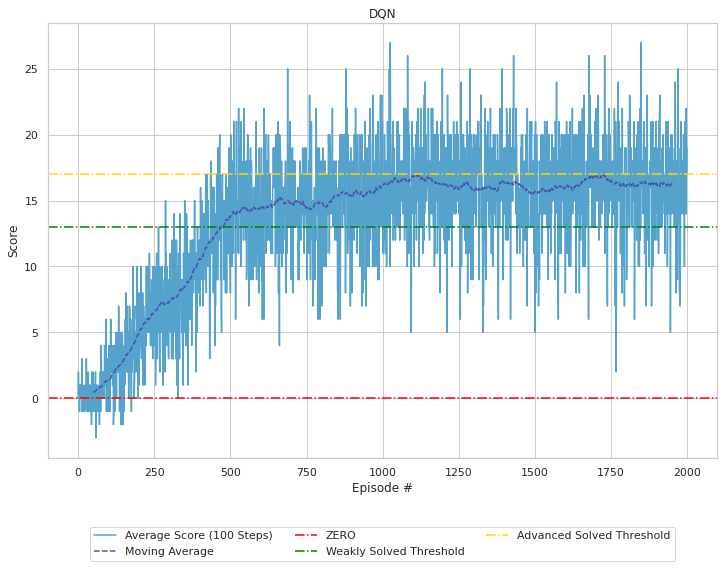

In [32]:
plot_scores(vanilla_dqn_scores, plot_title="DQN", N=100)

## Double DQN

In [15]:
lb = FullyConnectedBrain(state_size=37, action_size=4, seed=0, hidden_sizes=[128, 64, 16]).to(device) # Local Network
tb = FullyConnectedBrain(state_size=37, action_size=4, seed=0, hidden_sizes=[128, 64, 16]).to(device) # Target Network

double_dqn_agent = QAgentGeneric(state_size=37, action_size=4, seed=0, update_rule="double_dqn", local_brain=lb, target_brain=tb)

In [16]:
double_dqn_scores = dqn(double_dqn_agent, n_episodes=2000, max_t=1000, checkpoint_name='double_dqn', save_best=True, min_best=16)

Episode 100	Average Score: 0.51
Episode 200	Average Score: 3.97
Episode 300	Average Score: 7.91
Episode 400	Average Score: 10.76
Episode 500	Average Score: 12.24
Episode 600	Average Score: 14.68
Episode 700	Average Score: 13.56
Episode 800	Average Score: 15.14
Episode 866	Average Score: 16.05
Saved Best with Average Score of 16.05

Episode 883	Average Score: 16.08
Saved Best with Average Score of 16.08

Episode 885	Average Score: 16.10
Saved Best with Average Score of 16.1

Episode 886	Average Score: 16.16
Saved Best with Average Score of 16.16

Episode 888	Average Score: 16.17
Saved Best with Average Score of 16.17

Episode 900	Average Score: 16.16
Episode 901	Average Score: 16.19
Saved Best with Average Score of 16.19

Episode 902	Average Score: 16.22
Saved Best with Average Score of 16.22

Episode 903	Average Score: 16.28
Saved Best with Average Score of 16.28

Episode 904	Average Score: 16.33
Saved Best with Average Score of 16.33

Episode 905	Average Score: 16.43
Saved Best with A

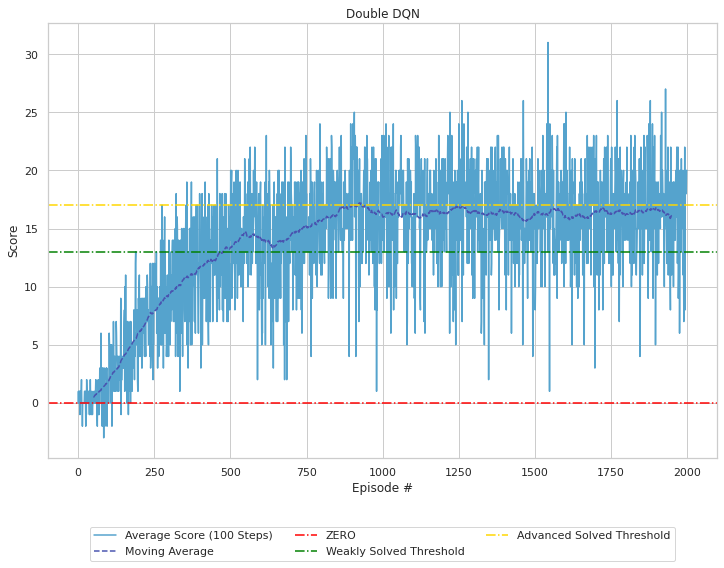

In [31]:
plot_scores(double_dqn_scores, plot_title="Double DQN", N=100)

## Dueling DQN (Vanilla)

In [21]:
lb = DuelingFullyConnectedBrain(state_size=37, action_size=4, seed=0, shared_hidden = [128, 64, 16], value_head=[32, 16], advantage_head=[32, 32]).to(device)  # Local Network
tb = DuelingFullyConnectedBrain(state_size=37, action_size=4, seed=0, shared_hidden = [128, 64, 16], value_head=[32, 16], advantage_head=[32, 32]).to(device)  # Target Network

dueling_dqn_agent = QAgentGeneric(state_size=37, action_size=4, seed=0, update_rule="dqn", local_brain=lb, target_brain=tb)

In [22]:
dueling_dqn_scores = dqn(dueling_dqn_agent, n_episodes=2000, max_t=1000, checkpoint_name='dueling_dqn', save_best=True, min_best=16)

Episode 100	Average Score: 1.07
Episode 200	Average Score: 4.01
Episode 300	Average Score: 8.11
Episode 400	Average Score: 11.48
Episode 500	Average Score: 14.26
Episode 600	Average Score: 14.57
Episode 700	Average Score: 15.83
Episode 764	Average Score: 16.01
Saved Best with Average Score of 16.01

Episode 765	Average Score: 16.04
Saved Best with Average Score of 16.04

Episode 766	Average Score: 16.07
Saved Best with Average Score of 16.07

Episode 767	Average Score: 16.08
Saved Best with Average Score of 16.08

Episode 773	Average Score: 16.09
Saved Best with Average Score of 16.09

Episode 775	Average Score: 16.11
Saved Best with Average Score of 16.11

Episode 778	Average Score: 16.16
Saved Best with Average Score of 16.16

Episode 780	Average Score: 16.18
Saved Best with Average Score of 16.18

Episode 784	Average Score: 16.21
Saved Best with Average Score of 16.21

Episode 800	Average Score: 15.94
Episode 817	Average Score: 16.22
Saved Best with Average Score of 16.22

Episode 8

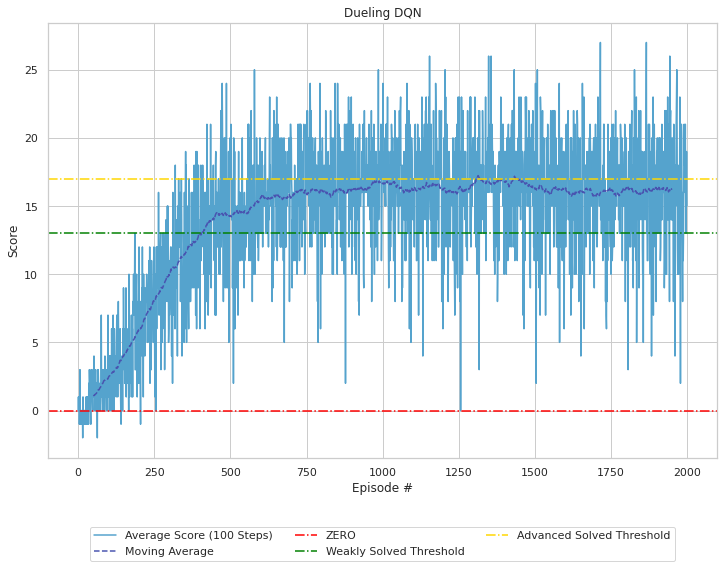

In [30]:
plot_scores(dueling_dqn_scores, plot_title="Dueling DQN", N=100)

## Dueling Double DQN

In [25]:
lb = DuelingFullyConnectedBrain(state_size=37, action_size=4, seed=0, shared_hidden = [128, 64, 16], value_head=[32, 16], advantage_head=[32, 32]).to(device)  # Local Network
tb = DuelingFullyConnectedBrain(state_size=37, action_size=4, seed=0, shared_hidden = [128, 64, 16], value_head=[32, 16], advantage_head=[32, 32]).to(device)  # Target Network

dueling_dobule_agent = QAgentGeneric(state_size=37, action_size=4, seed=0, update_rule="double_dqn", local_brain=lb, target_brain=tb)

In [26]:
dueling_dobule_scores = dqn(dueling_dobule_agent, n_episodes=2000, max_t=1000, checkpoint_name='dueling_double_dqn', save_best=True, min_best=16)

Episode 100	Average Score: 0.41
Episode 200	Average Score: 3.36
Episode 300	Average Score: 7.22
Episode 400	Average Score: 10.17
Episode 500	Average Score: 14.17
Episode 576	Average Score: 16.01
Saved Best with Average Score of 16.01

Episode 579	Average Score: 16.06
Saved Best with Average Score of 16.06

Episode 580	Average Score: 16.13
Saved Best with Average Score of 16.13

Episode 581	Average Score: 16.18
Saved Best with Average Score of 16.18

Episode 593	Average Score: 16.19
Saved Best with Average Score of 16.19

Episode 594	Average Score: 16.23
Saved Best with Average Score of 16.23

Episode 595	Average Score: 16.31
Saved Best with Average Score of 16.31

Episode 600	Average Score: 16.12
Episode 700	Average Score: 15.98
Episode 761	Average Score: 16.33
Saved Best with Average Score of 16.33

Episode 771	Average Score: 16.34
Saved Best with Average Score of 16.34

Episode 784	Average Score: 16.41
Saved Best with Average Score of 16.41

Episode 787	Average Score: 16.44
Saved Bes

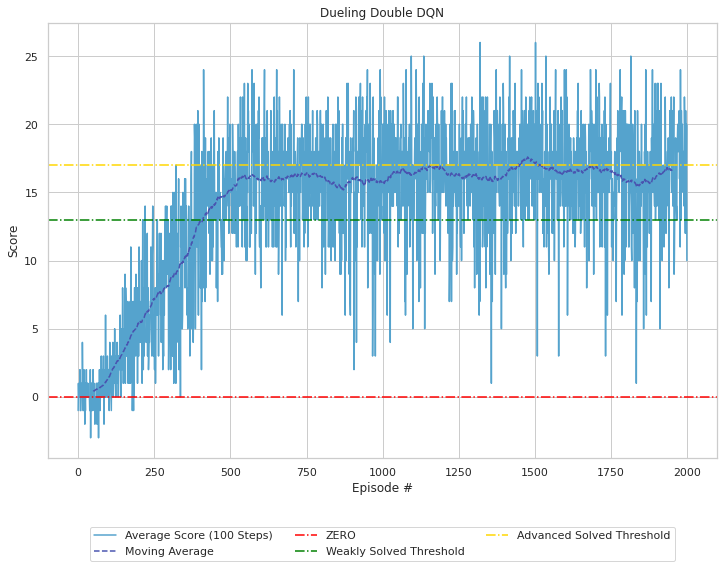

In [29]:
plot_scores(dueling_dobule_scores, plot_title="Dueling Double DQN", N=100)

## Comparing All together

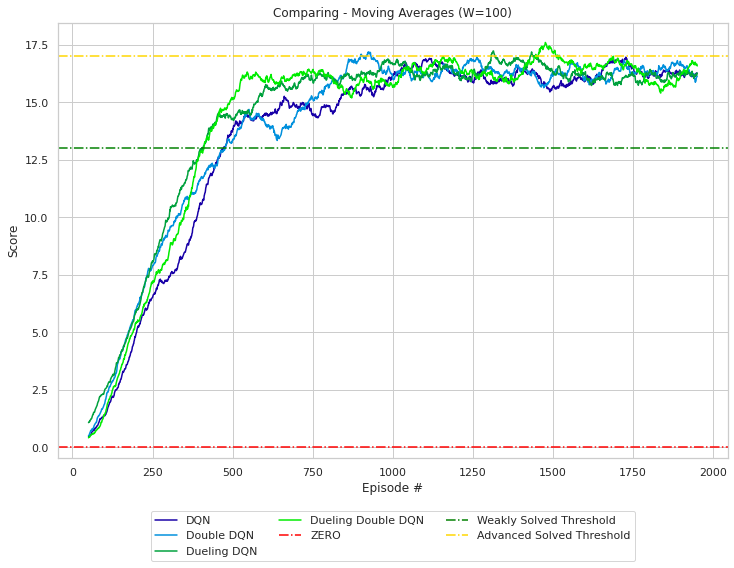

In [34]:
plot_average_scores([vanilla_dqn_scores, double_dqn_scores, dueling_dqn_scores, dueling_dobule_scores],
                    ["DQN", "Double DQN", "Dueling DQN", "Dueling Double DQN"],
                    N=100,
                    plot_title="Comparing - Moving Averages (W=100)")

### Finished? Turn off the lights and Close the ENV

In [35]:
env.close() 